#### Data Loading and cleaning

In [16]:
# Import libraries (add folium)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth, Marker
import requests
import json
import os
import webbrowser
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator

# Enable inline plotting
%matplotlib inline

In [17]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [18]:
# Load and clean datasets (run once if not already done)
def load_and_clean_data():
    df_athletes = pd.read_csv('athlete_events.csv')
    df_noc = pd.read_csv('noc_regions.csv')
    df = df_athletes.merge(df_noc[['NOC', 'region']], on='NOC', how='left')
    df.rename(columns={'region': 'Country'}, inplace=True)
    df['Medal'] = df['Medal'].fillna('None')
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Height'] = df['Height'].fillna(df['Height'].median())
    df['Weight'] = df['Weight'].fillna(df['Weight'].median())
    country_map = {
        'United States': 'USA',
        'United Kingdom': 'Great Britain',
        'Russia': 'RUS',
        'South Korea': 'KOR',
        'North Korea': 'PRK',
        'Germany': 'DEU',
        'East Germany': 'DEU',  # Historical mapping
        'West Germany': 'DEU',
        'Soviet Union': 'URS',  # Historical
        'Czechoslovakia': 'CZE',
        # Add more mappings as needed for historical NOCs
    }
    df['Country'] = df['Country'].replace(country_map)
    df = df.drop_duplicates(subset=['ID', 'Event', 'Year', 'Medal'])
    return df

# Load data (run once)
df = load_and_clean_data()

In [19]:

df.head(15)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None,China
2,3,Gunnar Nielsen Aaby,M,24.0,175.0,70.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None,Denmark
3,4,Edgar Lindenau Aabye,M,34.0,175.0,70.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None,Netherlands
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",None,Netherlands
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,None,Netherlands
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",None,Netherlands
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,None,Netherlands
9,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",None,Netherlands


In [20]:
# Check the range of years
min_year = df['Year'].min()
max_year = df['Year'].max()
print(f"Dataset covers years from {min_year} to {max_year}")

Dataset covers years from 1896 to 2016


#### 1. How many medals has Kenya won, and in which sports and events?

 QUESTION 1: SPORTS WITH MOST KENYAN MEDALS 


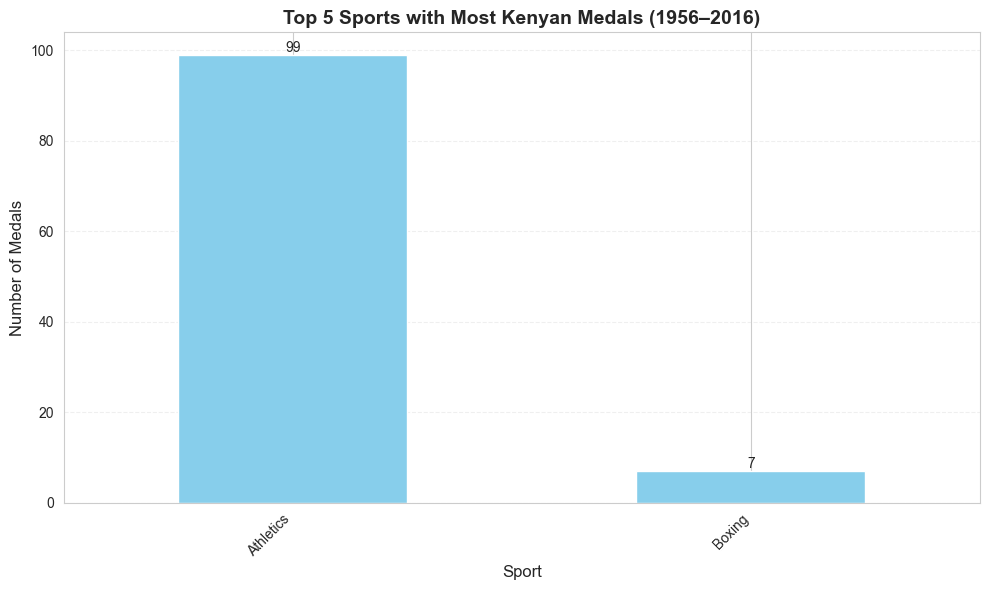

 TOP 5 SPORTS FOR KENYAN MEDALS (1956–2016) 
Sport
Athletics    99
Boxing        7
Name: ID, dtype: int64


In [21]:
def q1_kenya_top_sports():
    # Filter for Kenyan medals
    kenya_df = df[(df['NOC'] == 'KEN') & (df['Medal'] != 'None')]
    
    # Group by Sport and count medals
    sport_medals = kenya_df.groupby('Sport')['ID'].count().sort_values(ascending=False)
    
    # Get top 5 sports
    top_sports = sport_medals.head(5)
    
    # Create bar chart
    plt.figure(figsize=(10, 6))
    top_sports.plot(kind='bar', color='skyblue')
    plt.title("Top 5 Sports with Most Kenyan Medals (1956–2016)", fontsize=14, fontweight='bold')
    plt.xlabel('Sport', fontsize=12)
    plt.ylabel('Number of Medals', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on top of bars
    for i, v in enumerate(top_sports):
        plt.text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('kenya_top_sports_medals.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(" TOP 5 SPORTS FOR KENYAN MEDALS (1956–2016) ")
    print(top_sports)
    
    return top_sports

# Run Question 1
print(" QUESTION 1: SPORTS WITH MOST KENYAN MEDALS ")
top_sports = q1_kenya_top_sports()

#### 2. How have Kenya’s medal counts evolved over time (1956–2024)?

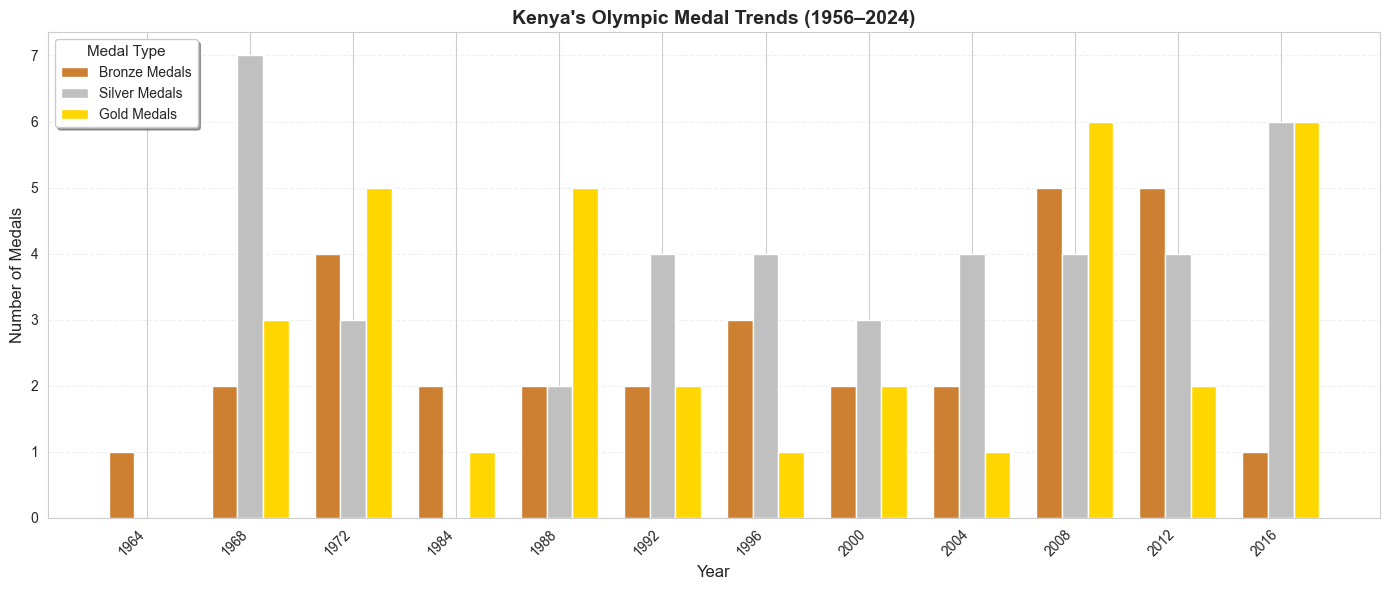

 KENYA'S MEDAL TRENDS (1956–2016) 
Year 1964: Gold=0, Silver=0, Bronze=1
Year 1968: Gold=3, Silver=7, Bronze=2
Year 1972: Gold=5, Silver=3, Bronze=4
Year 1984: Gold=1, Silver=0, Bronze=2
Year 1988: Gold=5, Silver=2, Bronze=2
Year 1992: Gold=2, Silver=4, Bronze=2
Year 1996: Gold=1, Silver=4, Bronze=3
Year 2000: Gold=2, Silver=3, Bronze=2
Year 2004: Gold=1, Silver=4, Bronze=2
Year 2008: Gold=6, Silver=4, Bronze=5
Year 2012: Gold=2, Silver=4, Bronze=5
Year 2016: Gold=6, Silver=6, Bronze=1


Medal,Bronze,Silver,Gold
Year,,,
1964,1,0,0
1968,2,7,3
1972,4,3,5
1984,2,0,1
1988,2,2,5
1992,2,4,2
1996,3,4,1
2000,2,3,2
2004,2,4,1


In [22]:
from matplotlib.ticker import FixedLocator
from matplotlib.patches import Patch

def q2_kenya_medal_trends(df):
    # Filter for Kenyan medals
    kenya_df = df[(df['NOC'] == 'KEN') & (df['Medal'] != 'None')]
    
    # Group by year and medal type
    medal_trends = kenya_df.groupby(['Year', 'Medal'])['ID'].count().unstack(fill_value=0)
    
    # Ensure all medal types exist
    medal_types = ['Bronze', 'Silver', 'Gold']
    medal_trends = medal_trends.reindex(columns=medal_types, fill_value=0)
    
    # Prepare data for plotting
    years = medal_trends.index
    gold_medals = medal_trends['Gold']
    silver_medals = medal_trends['Silver']
    bronze_medals = medal_trends['Bronze']
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    bar_width = 0.25
    index = range(len(years))
    
    # Plot bars
    ax.bar([x - bar_width for x in index], bronze_medals, bar_width, color='#CD7F32', label='Bronze')
    ax.bar(index, silver_medals, bar_width, color='silver', label='Silver')
    ax.bar([x + bar_width for x in index], gold_medals, bar_width, color='gold', label='Gold')
    
    # Customize the plot
    ax.set_title("Kenya's Olympic Medal Trends (1956–2024)", fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Medals', fontsize=12)
    ax.set_xticks(index)
    ax.set_xticklabels(years, rotation=45, ha='right', fontsize=10)
    
    # Add grid lines
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # --- Improved Legend ---
    legend_elements = [
        Patch(facecolor='#CD7F32', label='Bronze Medals'),
        Patch(facecolor='silver', label='Silver Medals'),
        Patch(facecolor='gold', label='Gold Medals')
    ]
    ax.legend(handles=legend_elements, title='Medal Type', loc='upper left',
              fontsize=10, title_fontsize=11, frameon=True, shadow=True)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('kenya_medal_trends_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print medal summary
    print(" KENYA'S MEDAL TRENDS (1956–2016) ")
    for year in years:
        print(f"Year {year}: Gold={gold_medals[year]}, Silver={silver_medals[year]}, Bronze={bronze_medals[year]}")
    
    return medal_trends


kenya_trends = q2_kenya_medal_trends(df)
kenya_trends

#### 3. What are the typical age and gender profiles of Kenyan medalists?

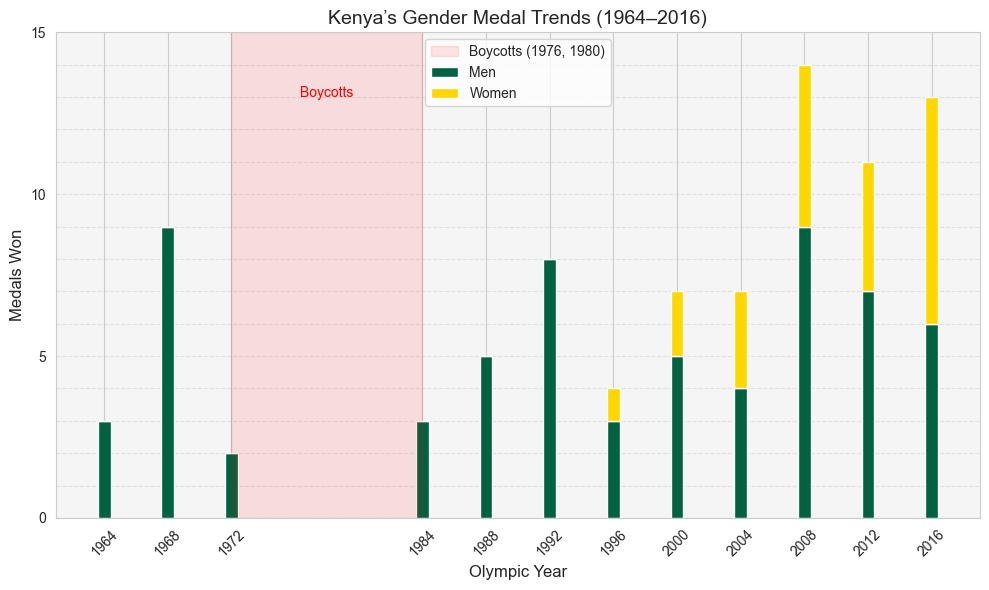

In [23]:


# Data (1956–2016, excluding boycotts for clarity)
years = [1964, 1968, 1972, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016]
men_medals = [3, 9, 2, 3, 5, 8, 3, 5, 4, 9, 7, 6]
women_medals = [0, 0, 0, 0, 0, 0, 1, 2, 3, 5, 4, 7]

# Create figure
plt.figure(figsize=(10, 6), dpi=100)  # Canva-friendly size
plt.bar(years, men_medals, color='#006241', label='Men')
plt.bar(years, women_medals, bottom=men_medals, color='#FFD700', label='Women')

# Axes with major/minor ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(8))  # Major ticks: every 8 years (1964, 1972, 1988, 1996, 2004, 2012)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))  # Minor ticks: every 2 years for finer granularity
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Major ticks: every 5 medals
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))  # Minor ticks: every 1 medal
ax.set_xticks(years)  # Show all years
ax.set_xticklabels(years, rotation=45, fontsize=10)
ax.set_xlabel('Olympic Year', fontsize=12)
ax.set_ylabel('Medals Won', fontsize=12)
ax.set_ylim(0, 15)  # Cap for readability

# Boycott shading
plt.axvspan(1972, 1984, color='red', alpha=0.1, label='Boycotts (1976, 1980)')
plt.text(1978, 13, 'Boycotts', fontsize=10, ha='center', color='red')

# Styling
plt.title('Kenya’s Gender Medal Trends (1964–2016)', fontsize=14)
plt.legend(loc='upper center', fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5, axis='y')
ax.set_facecolor('#F5F5F5')  # Light gray background
plt.tight_layout()

# Save for Canva
plt.savefig('kenya_gender_trends.png', bbox_inches='tight', dpi=300)
plt.show()  # Prevent display in non-interactive environments

 QUESTION 3: KENYAN MEDALISTS AGE AND GENDER PROFILES (PIE CHART) 


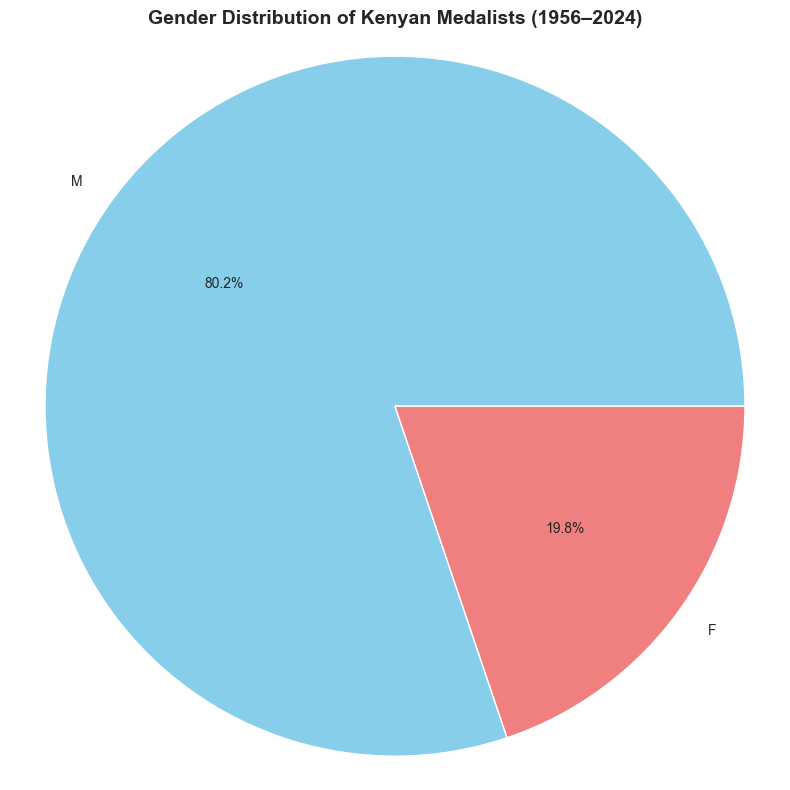

 GENDER DISTRIBUTION OF KENYAN MEDALISTS (1956–2016) 
Sex
M    85
F    21
Name: count, dtype: int64


In [24]:
def q3_kenya_medalist_gender_pie():
    # Filter for Kenyan medalists
    kenya_df = df[(df['NOC'] == 'KEN') & (df['Medal'] != 'None')]
    
    # Count by gender
    gender_counts = kenya_df['Sex'].value_counts()
    
    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
    plt.title("Gender Distribution of Kenyan Medalists (1956–2024)", fontsize=14, fontweight='bold')
    plt.axis('equal')  # Equal aspect ratio ensures a circular pie
    plt.tight_layout()
    plt.savefig('kenya_medalist_gender_pie.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(" GENDER DISTRIBUTION OF KENYAN MEDALISTS (1956–2016) ")
    print(gender_counts)
    
    return gender_counts


print(" QUESTION 3: KENYAN MEDALISTS AGE AND GENDER PROFILES (PIE CHART) ")
gender_distribution = q3_kenya_medalist_gender_pie()

#### 4. Which events does Kenya dominate compared to other countries?

 QUESTION 4: KENYAN MEDALISTS’ MOST SUCCESSFUL EVENTS 


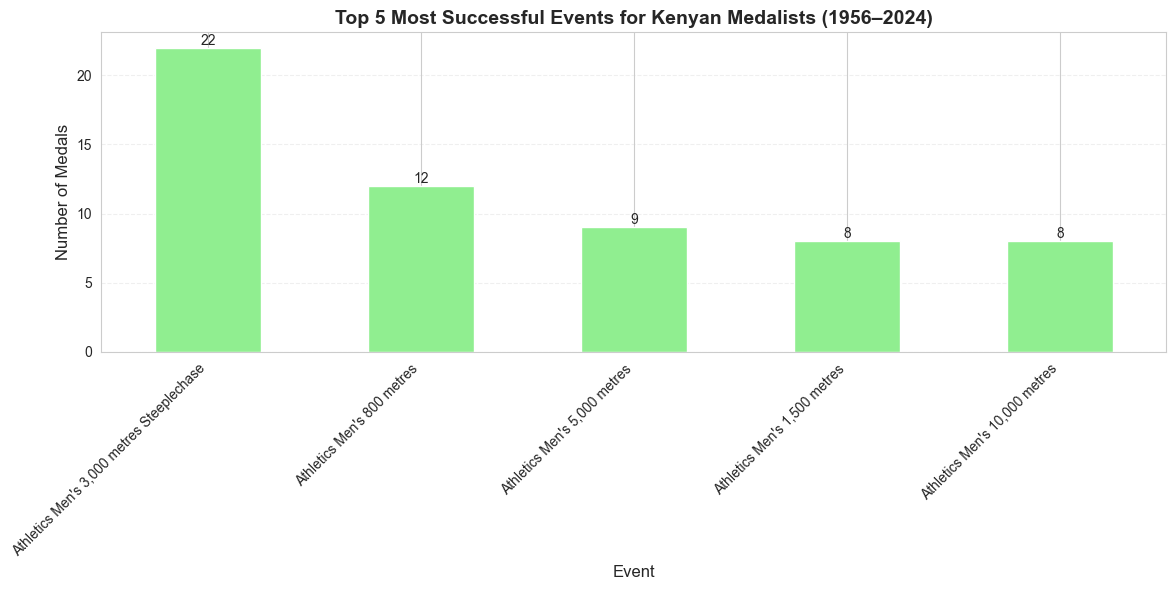

 TOP 5 MOST SUCCESSFUL EVENTS FOR KENYAN MEDALISTS (1956–2016) 
Event
Athletics Men's 3,000 metres Steeplechase    22
Athletics Men's 800 metres                   12
Athletics Men's 5,000 metres                  9
Athletics Men's 1,500 metres                  8
Athletics Men's 10,000 metres                 8
Name: ID, dtype: int64


In [25]:
def q4_kenya_top_events():
    # Filter for Kenyan medals
    kenya_df = df[(df['NOC'] == 'KEN') & (df['Medal'] != 'None')]
    
    # Group by Event and count medals
    event_medals = kenya_df.groupby('Event')['ID'].count().sort_values(ascending=False)
    
    # Get top 5 events
    top_events = event_medals.head(5)
    
    # Create bar chart
    plt.figure(figsize=(12, 6))
    top_events.plot(kind='bar', color='lightgreen')
    plt.title("Top 5 Most Successful Events for Kenyan Medalists (1956–2024)", fontsize=14, fontweight='bold')
    plt.xlabel('Event', fontsize=12)
    plt.ylabel('Number of Medals', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on top of bars
    for i, v in enumerate(top_events):
        plt.text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('kenya_top_events_medals.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(" TOP 5 MOST SUCCESSFUL EVENTS FOR KENYAN MEDALISTS (1956–2016) ")
    print(top_events)
    
    return top_events

# Run Question 4
print(" QUESTION 4: KENYAN MEDALISTS’ MOST SUCCESSFUL EVENTS ")
top_events = q4_kenya_top_events()

#### 5. Is there a time African countries were doing better than Kenya?

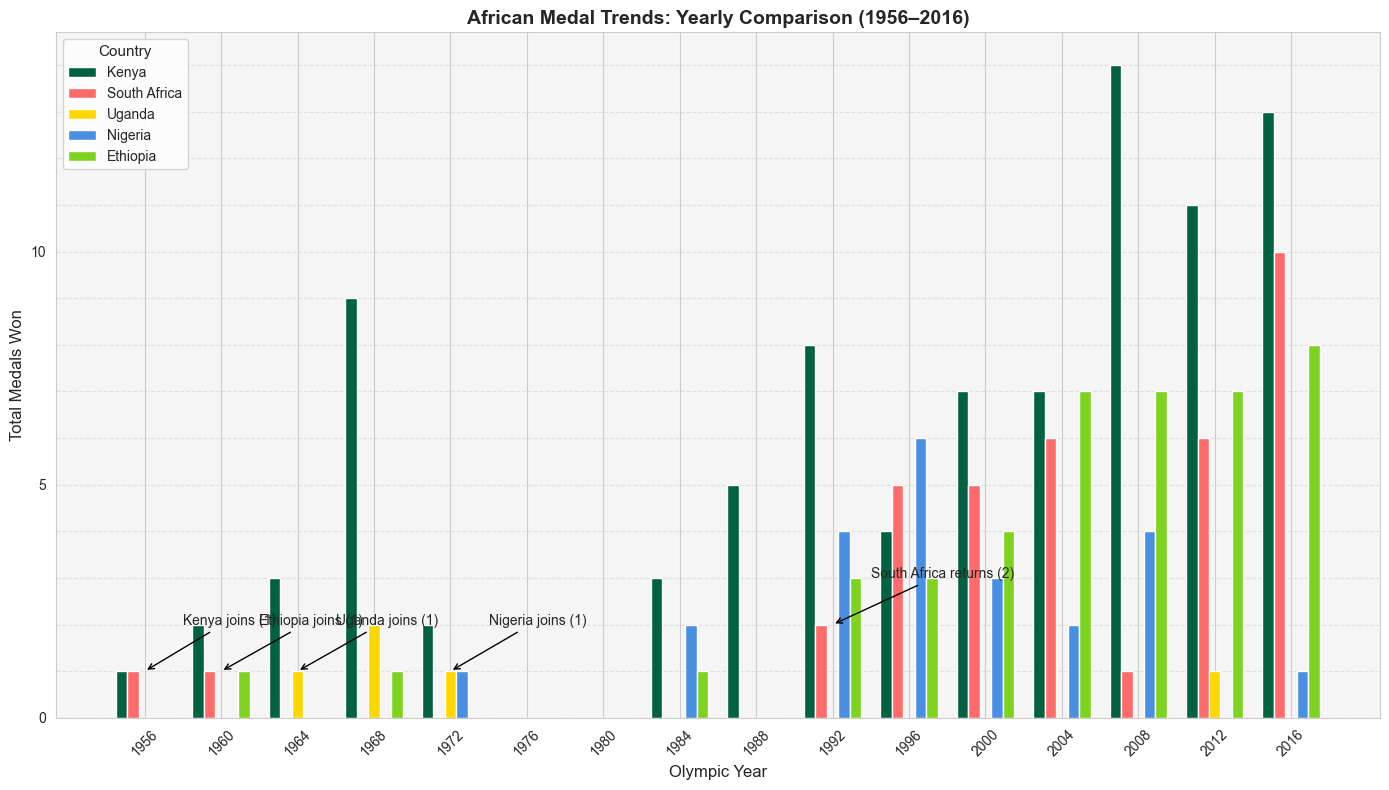

AFRICAN OLYMPIC MEDAL TRENDS (1956–2016) 
Kenya: [1, 2, 3, 9, 2, 0, 0, 3, 5, 8, 4, 7, 7, 14, 11, 13]
South Africa: [1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 5, 5, 6, 1, 6, 10]
Uganda: [0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Nigeria: [0, 0, 0, 0, 1, 0, 0, 2, 0, 4, 6, 3, 2, 4, 0, 1]
Ethiopia: [0, 1, 0, 1, 0, 0, 0, 1, 0, 3, 3, 4, 7, 7, 7, 8]


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def q3_african_medal_trends():
    # --- Data: Olympic Years & Medals (1956–2016) ---
    years = [1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 
             1992, 1996, 2000, 2004, 2008, 2012, 2016]
    
    kenya = [1, 2, 3, 9, 2, 0, 0, 3, 5, 8, 4, 7, 7, 14, 11, 13]
    south_africa = [1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 5, 5, 6, 1, 6, 10]
    uganda = [0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
    nigeria = [0, 0, 0, 0, 1, 0, 0, 2, 0, 4, 6, 3, 2, 4, 0, 1]
    ethiopia = [0, 1, 0, 1, 0, 0, 0, 1, 0, 3, 3, 4, 7, 7, 7, 8]

    # --- Create figure ---
    fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
    x = np.arange(len(years))
    width = 0.15  # Bar width for 5 countries

    # --- Plot bars for each country ---
    ax.bar(x - 2*width, kenya, width, label='Kenya', color='#006241')
    ax.bar(x - width, south_africa, width, label='South Africa', color='#FF6B6B')
    ax.bar(x, uganda, width, label='Uganda', color='#FFD700')
    ax.bar(x + width, nigeria, width, label='Nigeria', color='#4A90E2')
    ax.bar(x + 2*width, ethiopia, width, label='Ethiopia', color='#7ED321')

    # --- Axes setup ---
    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=45)
    ax.set_xlabel('Olympic Year', fontsize=12)
    ax.set_ylabel('Total Medals Won', fontsize=12)
    ax.set_title('African Medal Trends: Yearly Comparison (1956–2016)', fontsize=14, fontweight='bold')

    # --- Grid setup ---
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, which='both', linestyle='--', alpha=0.5, axis='y')
    ax.set_facecolor('#F5F5F5')

    # --- Annotations for key moments ---
    ax.annotate('Kenya joins (1)', xy=(0, 1), xytext=(0.5, 2),
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('Ethiopia joins (1)', xy=(1, 1), xytext=(1.5, 2),
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('Uganda joins (1)', xy=(2, 1), xytext=(2.5, 2),
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('Nigeria joins (1)', xy=(4, 1), xytext=(4.5, 2),
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('South Africa returns (2)', xy=(9, 2), xytext=(9.5, 3),
                arrowprops=dict(arrowstyle='->', color='black'))

    # --- Legend ---
    ax.legend(title='Country', loc='upper left', fontsize=10, title_fontsize=11, frameon=True)

    # --- Layout & Save ---
    plt.tight_layout()
    plt.savefig('african_medal_trends.png', bbox_inches='tight', dpi=300)
    plt.show()

    # --- Print Summary ---
    print("AFRICAN OLYMPIC MEDAL TRENDS (1956–2016) ")
    print("Kenya:", kenya)
    print("South Africa:", south_africa)
    print("Uganda:", uganda)
    print("Nigeria:", nigeria)
    print("Ethiopia:", ethiopia)

# Run function
q3_african_medal_trends()


#### 6. Underdog sports Kenya tried beyond athletics

In [27]:
def q6_kenya_underdog_sports():
    kenya_non_athletics = df[(df['NOC'] == 'KEN') & (df['Sport'] != 'Athletics')]
    non_athletics_medals = kenya_non_athletics[kenya_non_athletics['Medal'] != 'None'].groupby('Sport')['ID'].count()
    participation = kenya_non_athletics['Sport'].value_counts()
    
    # Bar chart: Participation in non-athletics sports
    plt.figure(figsize=(10, 6))
    participation.plot(kind='bar', color='orange')
    plt.title("Kenya's Participation in Non-Athletics Sports")
    plt.xlabel('Sport')
    plt.ylabel('Number of participants')
    plt.tight_layout()
    plt.savefig('kenya_non_athletics_participation.png')
    plt.show()
    
    return non_athletics_medals, participation


Question 6: Kenya's Underdog Sports


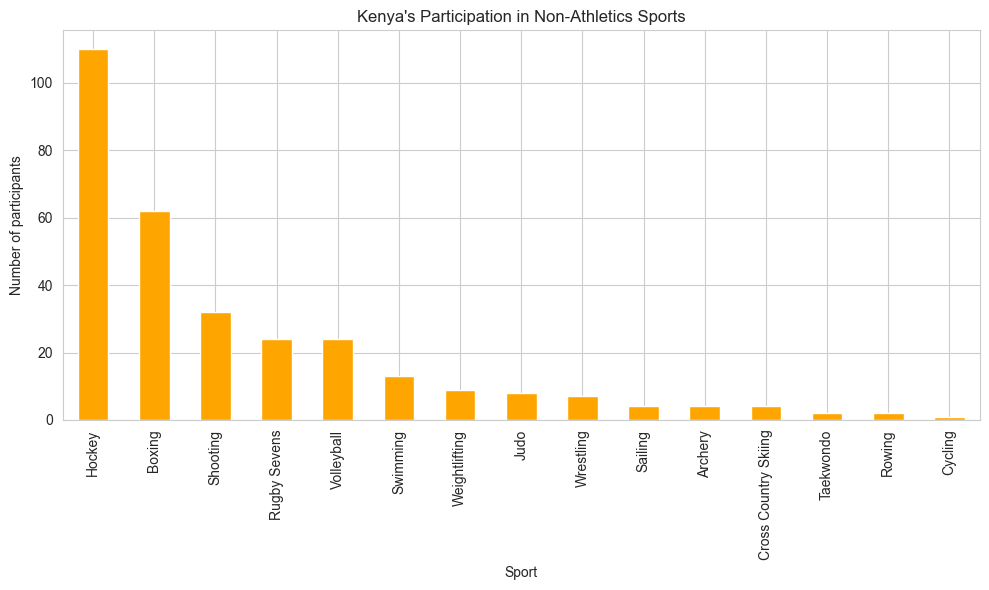

Non-Athletics Medals:
Sport
Boxing    7
Name: ID, dtype: int64

Participation in Non-Athletics Sports:
Sport
Hockey                  110
Boxing                   62
Shooting                 32
Rugby Sevens             24
Volleyball               24
Swimming                 13
Weightlifting             9
Judo                      8
Wrestling                 7
Sailing                   4
Archery                   4
Cross Country Skiing      4
Taekwondo                 2
Rowing                    2
Cycling                   1
Name: count, dtype: int64


In [28]:
print("\nQuestion 6: Kenya's Underdog Sports")
non_athletics_medals, participation = q6_kenya_underdog_sports()
print("Non-Athletics Medals:")
print(non_athletics_medals)
print("\nParticipation in Non-Athletics Sports:")
print(participation)

#### 7. Does Kenya’s medal efficiency outrank other nations?

 QUESTION 7: ENHANCED MEDAL EFFICIENCY (2000–2016)
Top Countries by Medal Efficiency (2000–2016):
        Country  Efficiency
0           USA       0.630
1       Jamaica       0.625
2        Norway       0.510
3           RUS       0.500
4   Netherlands       0.472
5           DEU       0.446
6       Bahamas       0.411
7     Australia       0.389
8         China       0.384
9        Serbia       0.374
10     Paraguay       0.370
11       Sweden       0.360
12         Cuba       0.353
13           UK       0.349
14      Denmark       0.333
15      Finland       0.332
16     Ethiopia       0.330
17       Canada       0.327
18          KOR       0.323
19      Romania       0.302
20      Croatia       0.302
21       France       0.294
22        Italy       0.290
23      Hungary       0.285
24       Brazil       0.283
31        Kenya       0.240

Kenya's Efficiency (2000–2016): 0.240


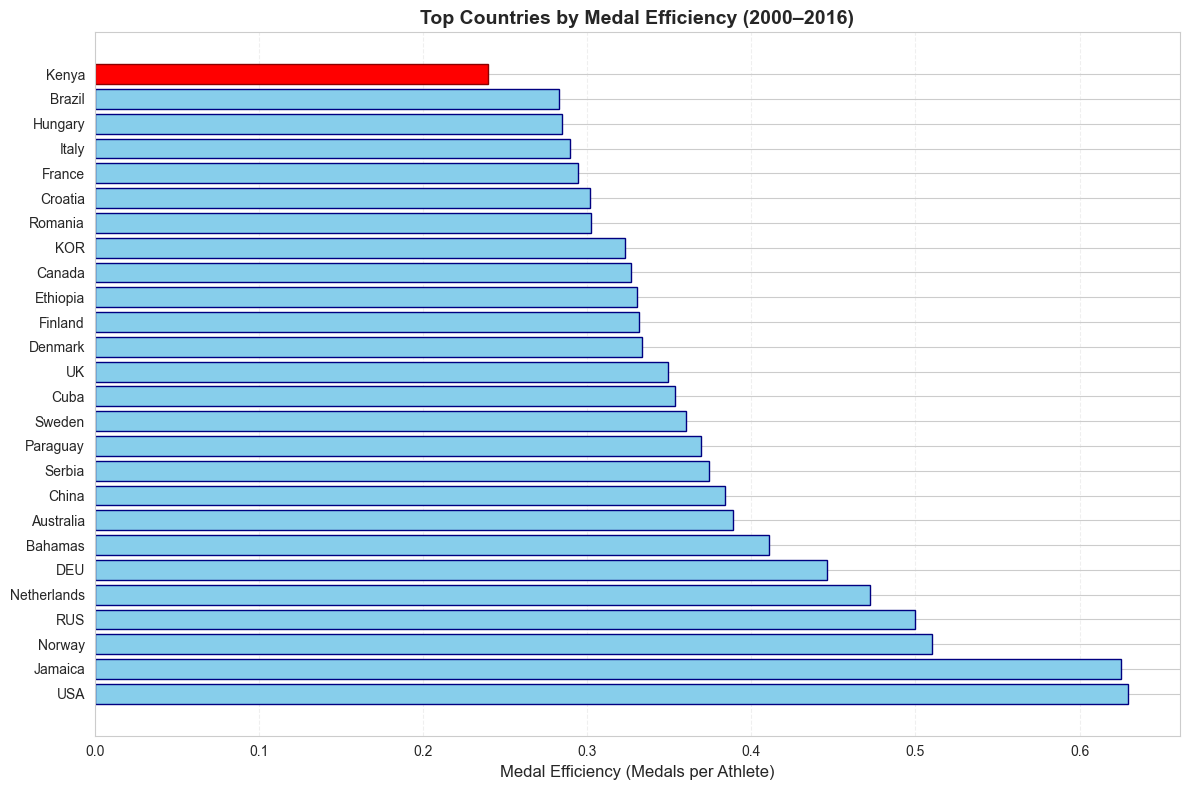

In [29]:
def q7_medal_efficiency():
    # Filter dataset for years 2000 to 2016
    df_filtered = df[(df['Year'] >= 2000) & (df['Year'] <= 2016)]
    
    # Calculate medals and athletes per country for the filtered period
    medals = df_filtered[df_filtered['Medal'] != 'None'].groupby('NOC')['ID'].count()
    athletes = df_filtered.groupby('NOC')['ID'].nunique()
    efficiency = (medals / athletes).dropna().sort_values(ascending=False)
    
    # Convert NOC to country names for better readability
    efficiency_df = pd.DataFrame({
        'NOC': efficiency.index,
        'Efficiency': efficiency.values
    })
    efficiency_df = efficiency_df.merge(df[['NOC', 'Country']].drop_duplicates(), on='NOC', how='left')
    
    # Get top 25 (to ensure Kenya is likely included) and Kenya specifically
    top_25_eff = efficiency_df.head(25)
    kenya_eff = efficiency_df[efficiency_df['Country'].str.contains('Kenya', case=False, na=False)]
    
    # Ensure Kenya is in the list, even if not in top 25
    if not kenya_eff.empty and kenya_eff.index[0] not in top_25_eff.index:
        top_25_eff = pd.concat([top_25_eff, kenya_eff]).drop_duplicates().sort_values('Efficiency', ascending=False)
    
    print("Top Countries by Medal Efficiency (2000–2016):")
    print(top_25_eff[['Country', 'Efficiency']].round(3))
    print(f"\nKenya's Efficiency (2000–2016): {kenya_eff['Efficiency'].iloc[0]:.3f}" if not kenya_eff.empty else "\nKenya not found in data")
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    y_pos = range(len(top_25_eff))
    
    # Plot all top 25 with Kenya highlighted
    bars = plt.barh(y_pos, top_25_eff['Efficiency'], align='center', color='skyblue', edgecolor='navy')
    if not kenya_eff.empty:
        kenya_idx = top_25_eff.index[top_25_eff['NOC'] == kenya_eff['NOC'].iloc[0]]
        if len(kenya_idx) > 0:
            bars[top_25_eff.index.get_loc(kenya_idx[0])].set_color('red')
            bars[top_25_eff.index.get_loc(kenya_idx[0])].set_edgecolor('darkred')
    
    plt.yticks(y_pos, top_25_eff['Country'], fontsize=10)
    plt.xlabel('Medal Efficiency (Medals per Athlete)', fontsize=12)
    plt.title('Top Countries by Medal Efficiency (2000–2016)', fontsize=14, fontweight='bold')
    plt.grid(True, axis='x', alpha=0.3, linestyle='--')
    
    # Customize layout
    plt.tight_layout()
    plt.savefig('medal_efficiency_top25_2000_2016.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return efficiency.head(10), efficiency.get('KEN', 0)

# Run Question 7
print(" QUESTION 7: ENHANCED MEDAL EFFICIENCY (2000–2016)")
top_efficiency, kenya_efficiency = q7_medal_efficiency()

#### 8. How are Olympic medals distributed geographically? with Folium map

In [35]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import webbrowser
from IPython.display import display
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter

def q8_global_medal_map_folium():
    # Aggregate medals by country
    global_medals = df[df['Medal'] != 'None'].groupby(['Country', 'NOC']).agg({
        'ID': 'count'
    }).reset_index()
    global_medals.columns = ['Country', 'NOC', 'Total_Medals']
    total_countries = len(global_medals)
    print(f"Total countries with medals: {total_countries}")
    
    # Calculate efficiency for marker sizing
    athletes = df.groupby('NOC')['ID'].nunique()
    global_medals = global_medals.merge(athletes.rename('Total_Athletes'), left_on='NOC', right_index=True, how='left')
    global_medals['Efficiency'] = global_medals['Total_Medals'] / global_medals['Total_Athletes']
    global_medals = global_medals.fillna(0)
    
    # Fetch and load GeoJSON for country boundaries
    geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'
    response = requests.get(geojson_url)
    if response.status_code != 200:
        raise ValueError(f"Failed to fetch GeoJSON: Status code {response.status_code}")
    geojson_data = response.json()
    
    # Create country to coordinates mapping (simplified - using approximate centroids)
    country_coords = {
        'United States': [37.0902, -95.7129],
        'Russia': [61.5240, 105.3188],
        "People's Republic of China": [35.8617, 104.1954],
        'United Kingdom': [55.3781, -3.4360],
        'Germany': [51.1657, 10.4515],
        'France': [46.2276, 2.2137],
        'Italy': [41.8719, 12.5674],
        'Japan': [36.2048, 138.2529],
        'Australia': [-25.2744, 133.7751],
        'Canada': [56.1304, -106.3468],
        'Spain': [40.4637, -3.7492],
        'Netherlands': [52.1326, 5.2913],
        'Sweden': [60.1282, 18.6435],
        'Hungary': [47.1625, 19.5033],
        'Kenya': [-1.2921, 36.8219],
        'Ethiopia': [9.1450, 40.4897],
        'South Africa': [-30.5595, 22.9375],
        'Cuba': [21.5218, -77.7812],
        'Romania': [45.9432, 24.9668],
        'Poland': [51.9194, 19.1451],
        # Add more as needed based on your top countries
    }
    
    # Initialize Folium map
    folium_map = folium.Map(location=[0, 0], zoom_start=2, tiles='OpenStreetMap')
    print("Folium map initialized with markers for all countries.")
    
    # Add markers for all countries with medals
    marker_count = 0
    for _, country in global_medals.iterrows():
        country_name = country['Country']
        medals = country['Total_Medals']
        efficiency = country['Efficiency']
        
        # Get coordinates (use default if not in mapping)
        coords = country_coords.get(country_name, [20, 0])  # Default to approximate global center
        
        if medals > 0:  # Only add markers for countries with medals
            # Color based on medal count
            if medals >= 1000:
                color = 'darkred'
            elif medals >= 500:
                color = 'red'
            elif medals >= 100:
                color = 'orange'
            elif medals >= 50:
                color = 'yellow'
            elif medals >= 10:
                color = 'lightgreen'
            else:
                color = 'green'
            
            # Size based on efficiency
            size = max(8, min(20, int(efficiency * 1000)))  # Scale efficiency to marker size
            
            # Create marker
            folium.CircleMarker(
                location=coords,
                radius=size,
                popup=folium.Popup(f"""
                    <b>{country_name}</b><br>
                    Total Medals: {medals}<br>
                    Athletes: {int(country['Total_Athletes'])}<br>
                    Efficiency: {efficiency:.3f} medals/athlete<br>
                    NOC: {country['NOC']}
                """, max_width=300),
                tooltip=f"{country_name}: {medals} medals",
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7,
                weight=1
            ).add_to(folium_map)
            marker_count += 1
    
    # Special highlight for Kenya
    kenya_data = global_medals[global_medals['Country'].str.contains('Kenya', case=False, na=False)]
    if not kenya_data.empty:
        kenya_coords = [-1.2921, 36.8219]
        kenya_medals = kenya_data['Total_Medals'].iloc[0]
        kenya_efficiency = kenya_data['Efficiency'].iloc[0]
        
        folium.Marker(
            location=kenya_coords,
            popup=folium.Popup(f"""
                <b>🇰🇪 KENYA (Special Highlight)</b><br>
                Total Medals: {kenya_medals}<br>
                Athletes: {int(kenya_data['Total_Athletes'].iloc[0])}<br>
                Efficiency: {kenya_efficiency:.3f} medals/athlete<br>
                <b>Top African Nation!</b>
            """, max_width=300),
            tooltip=f"Kenya: {kenya_medals} medals ({kenya_efficiency:.3f} efficiency)",
            icon=folium.Icon(color='red', icon='star', prefix='fa', icon_color='gold')
        ).add_to(folium_map)
        print(f"Kenya highlighted: {kenya_medals} medals, {kenya_efficiency:.3f} efficiency")
    
    # Add legend for marker colors
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 140px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <b>Medal Count Legend</b><br>
    <i class="fa fa-circle" style="color:darkred"></i> 1000+ medals<br>
    <i class="fa fa-circle" style="color:red"></i> 500-999 medals<br>
    <i class="fa fa-circle" style="color:orange"></i> 100-499 medals<br>
    <i class="fa fa-circle" style="color:yellow"></i> 50-99 medals<br>
    <i class="fa fa-circle" style="color:lightgreen"></i> 10-49 medals<br>
    <i class="fa fa-circle" style="color:green"></i> 1-9 medals<br>
    <i class="fa fa-star" style="color:red"></i> Kenya (Highlighted)
    </div>
    '''
    folium_map.get_root().html.add_child(folium.Element(legend_html))
    
    # Save and display
    folium_map.save('global_medal_map_all_markers.html')
    print(f"Map with {marker_count} country markers saved to {os.path.abspath('global_medal_map_all_markers.html')}")
    
    try:
        display(folium_map._repr_html_())
        print("Map displayed inline successfully.")
    except Exception as e:
        print(f"Error displaying map inline: {e}")
        print("Please open the saved HTML file in a web browser.")
        webbrowser.open(f'file://{os.path.abspath("global_medal_map_all_markers.html")}')
    
    # Static bar chart for top 20
    top_20 = global_medals.sort_values('Total_Medals', ascending=False).head(20)
    plt.figure(figsize=(14, 6))
    sns.barplot

q8_global_medal_map_folium()

Total countries with medals: 148
Folium map initialized with markers for all countries.
Kenya highlighted: 106 medals, 0.206 efficiency
Map with 148 country markers saved to c:\Users\user\Desktop\pydata-capstone\Pydata-capstone-project\global_medal_map_all_markers.html


'<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe srcdoc="&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&gt;\n    \n    &lt;meta http-equiv=&quot;content-type&quot; content=&quot;text/html; charset=UTF-8&quot; /&gt;\n    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://code.jquery.com/jquery-3.7.1.min.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js&quot;&gt;&lt;/script&gt;\n    &lt;link rel=&quot;stylesheet&quot; href=&quot;https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css&quot;/&gt;\n    &lt;link rel=&quot;styles

Map displayed inline successfully.


<Figure size 1400x600 with 0 Axes>